In [4]:
import numpy as np
import jax
from jax import numpy as jnp
import distrax
import haiku as hk
from ima.upsamling import Pad
from jax.experimental.optimizers import adam
from tqdm import tqdm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [16]:
def plot_all(mani,cima,loglikeint):  

    cimaint = loglikeint+20000
    exp = '/cobra/u/jsliwa/Doc/out/swiss_roll/grid_search2/'+str(mani)+'mani/'+str(cima)+'cima/'+str(loglikeint)+'loglikeint/'+str(cimaint)+'cima_int/'

    x_train = jnp.array(jnp.load(exp+'data/sourcesx_train.npy'))
    x_test = jnp.array(jnp.load(exp+'data/sourcesx_test.npy'))
    y_train = jnp.array(jnp.load(exp+'data/sourcesy_train.npy'))
    y_test = jnp.array(jnp.load(exp+'data/sourcesy_test.npy'))
    obs_train = jnp.array(jnp.load(exp+'data/mani_train.npy'))
    obs_test = jnp.array(jnp.load(exp+'data/mani_test.npy'))
    params_manifold = hk.data_structures.to_immutable_dict(jnp.load(exp+'checkpoints/params_manifold.npy', allow_pickle=True).item())
    params_dist = hk.data_structures.to_immutable_dict(jnp.load(exp+'checkpoints/params_dist.npy', allow_pickle=True).item())
    params_cima = hk.data_structures.to_immutable_dict(jnp.load(exp+'checkpoints/params_cima.npy', allow_pickle=True).item())

    sources_mani = jnp.array(jnp.load(exp+'checkpoints/sources_manifold.npy'))
    mani_mani= jnp.array(jnp.load(exp+'checkpoints/manifold_manifold.npy'))
    sources_dist = jnp.array(jnp.load(exp+'checkpoints/sources_dist.npy'))
    mani_dist = jnp.array(jnp.load(exp+'checkpoints/manifold_dist.npy'))
    sources_cima = jnp.array(jnp.load(exp+'checkpoints/sources_cima.npy'))
    mani_cima = jnp.array(jnp.load(exp+'checkpoints/manifold_cima.npy'))


    loss_hist = np.loadtxt(exp+'log/loss.csv', skiprows=1, delimiter=',')
    loss_manifold_hist = np.loadtxt(exp+'log/loss_mani.csv', skiprows=1, delimiter=',')
    loss_dist_hist = np.loadtxt(exp+'log/loss_dist.csv', skiprows=1, delimiter=',')
    loss_cima_hist = np.loadtxt(exp+'log/loss_cima.csv', skiprows=1, delimiter=',')

    from ima.plotting import cart2pol 
    cmap = 'hsv'

    _, colors = cart2pol(x_train, y_train)
    
    import statsmodels.api as sm
    
    fig1 = plt.figure(figsize=(20, 5))
    plt.plot(loss_hist[:, 0], loss_hist[:, 1])
    plt.ylim([0,0.3])
    plt.title(str(mani)+','+str(cima)+','+str(loglikeint),fontsize=28)
    fig2 = plt.figure(figsize = (20,25)) 


    ax = fig2.add_subplot(5,4,13)
    ax.scatter(x_train, y_train, c=colors, cmap='hsv')
    ax.set_ylim([-0.6,0.6])
    ax.set_xlim([-0.6,0.6])
    ax = fig2.add_subplot(5,4,17, projection = "3d")
    ax.scatter(obs_train[:,0], obs_train[:,1], obs_train[:,2], c=colors, cmap='hsv')


    ax = fig2.add_subplot(5,4,2)
    ax.plot(loss_manifold_hist[:, 0], loss_manifold_hist[:, 1])
    ax.set_ylim([0,0.3])
    ax = fig2.add_subplot(5,4,6)
    ax.scatter(sources_mani[:,0], sources_mani[:,1], c=colors, cmap='hsv')
    #ax.set_ylim([-0.6,0.6])
    #ax.set_xlim([-0.6,0.6])
    ax = fig2.add_subplot(5,4,10)
    sources_in = jax.scipy.stats.logistic.cdf(sources_mani) - 0.5
    ax.scatter(sources_in[:,0], sources_in[:,1], c=colors, cmap='hsv')
    ax.set_ylim([-0.6,0.6])
    ax.set_xlim([-0.6,0.6])
    ax = fig2.add_subplot(5,4,14)
    ecdfx, ecdfy = sm.distributions.ECDF(sources_mani[:,0]), sm.distributions.ECDF(sources_mani[:,1])
    S_rec_emp_trainx, S_rec_emp_trainy = ecdfx(sources_mani[:,0])-0.5, ecdfy(sources_mani[:,1])-0.5
    S_rec_emp_train = np.vstack((S_rec_emp_trainx,S_rec_emp_trainy)).T
    sources_in = S_rec_emp_train
    ax.scatter(sources_in[:,0], sources_in[:,1], c=colors, cmap='hsv')
    ax.set_ylim([-0.6,0.6])
    ax.set_xlim([-0.6,0.6])
    ax = fig2.add_subplot(5,4,18, projection = "3d")
    ax.scatter(mani_mani[:,0], mani_mani[:,1], mani_mani[:,2], c=colors, cmap='hsv')

    ax = fig2.add_subplot(5,4,3)
    ax.plot(loss_dist_hist[:, 0], loss_dist_hist[:, 1])
    ax.set_ylim([0,0.3])
    ax = fig2.add_subplot(5,4,7)
    ax.scatter(sources_dist[:,0], sources_dist[:,1], c=colors, cmap='hsv')
    #ax.set_ylim([-0.6,0.6])
    #ax.set_xlim([-0.6,0.6])
    ax = fig2.add_subplot(5,4,11)
    sources_in = jax.scipy.stats.logistic.cdf(sources_dist) - 0.5
    ax.scatter(sources_in[:,0], sources_in[:,1], c=colors, cmap='hsv')
    ax.set_ylim([-0.6,0.6])
    ax.set_xlim([-0.6,0.6])
    ax = fig2.add_subplot(5,4,15)
    ecdfx, ecdfy = sm.distributions.ECDF(sources_dist[:,0]), sm.distributions.ECDF(sources_dist[:,1])
    S_rec_emp_trainx, S_rec_emp_trainy = ecdfx(sources_dist[:,0])-0.5, ecdfy(sources_dist[:,1])-0.5
    S_rec_emp_train = np.vstack((S_rec_emp_trainx,S_rec_emp_trainy)).T
    sources_in = S_rec_emp_train
    ax.scatter(sources_in[:,0], sources_in[:,1], c=colors, cmap='hsv')
    ax.set_ylim([-0.6,0.6])
    ax.set_xlim([-0.6,0.6])
    ax = fig2.add_subplot(5,4,19, projection = "3d")
    ax.scatter(mani_dist[:,0], mani_dist[:,1], mani_dist[:,2], c=colors, cmap='hsv')


    ax = fig2.add_subplot(5,4,4)
    ax.plot(loss_cima_hist[:, 0], loss_cima_hist[:, 1])
    ax.set_ylim([0,0.3])
    ax = fig2.add_subplot(5,4,8)
    ax.scatter(sources_cima[:,0], sources_cima[:,1], c=colors, cmap='hsv')
    #ax.set_ylim([-0.6,0.6])
    #ax.set_xlim([-0.6,0.6])
    ax = fig2.add_subplot(5,4,12)
    sources_in = jax.scipy.stats.logistic.cdf(sources_cima) - 0.5
    ax.scatter(sources_in[:,0], sources_in[:,1], c=colors, cmap='hsv')
    ax.set_ylim([-0.6,0.6])
    ax.set_xlim([-0.6,0.6])
    ax = fig2.add_subplot(5,4,16)
    S_train = np.vstack((x_train,y_train)).T
    ecdfx, ecdfy = sm.distributions.ECDF(sources_cima[:,0]), sm.distributions.ECDF(sources_cima[:,1])
    S_rec_emp_trainx, S_rec_emp_trainy = ecdfx(sources_cima[:,0])-0.5, ecdfy(sources_cima[:,1])-0.5
    S_rec_emp_train = np.vstack((S_rec_emp_trainx,S_rec_emp_trainy)).T
    sources_in = S_rec_emp_train
    ax.scatter(sources_in[:,0], sources_in[:,1], c=colors, cmap='hsv')
    ax.set_ylim([-0.6,0.6])
    ax.set_xlim([-0.6,0.6])
    ax = fig2.add_subplot(5,4,20, projection = "3d")
    ax.scatter(mani_cima[:,0], mani_cima[:,1], mani_cima[:,2], c=colors, cmap='hsv')

    plt.show()
    
    fig3 = plt.figure(figsize = (20,5)) 



    ax = fig3.add_subplot(1,4,1)
    ax.scatter(obs_train[:,0], obs_train[:,2], c=colors, cmap='hsv')
    ax = fig3.add_subplot(1,4,2)
    ax.scatter(mani_mani[:,0], mani_mani[:,2], c=colors, cmap='hsv')
    ax = fig3.add_subplot(1,4,3)
    ax.scatter(mani_dist[:,0], mani_dist[:,2], c=colors, cmap='hsv')
    ax = fig3.add_subplot(1,4,4)
    ax.scatter(mani_cima[:,0], mani_cima[:,2], c=colors, cmap='hsv')
    plt.show()

    mcc_emp = np.loadtxt(exp+'/log/mcc_emp_train.csv',skiprows=1, delimiter=',')
    mcc_log = np.loadtxt(exp+'/log/mcc_emp_train.csv',skiprows=1, delimiter=',')

    fig1 = plt.figure(figsize=(20, 5))
    plt.plot(mcc_log[:,0],mcc_log[:,1])
    plt.axvline(loglikeint, c='red')
    plt.axvline(cimaint, c='red')
    plt.show()
    #print('\n\n\n\n\n')

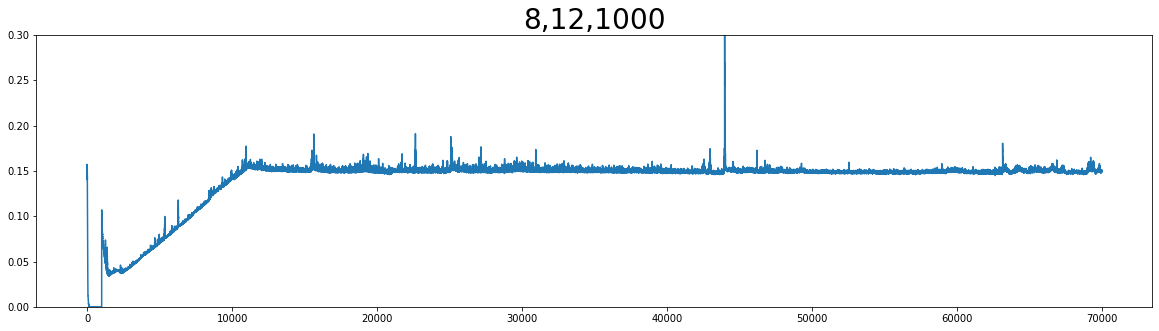

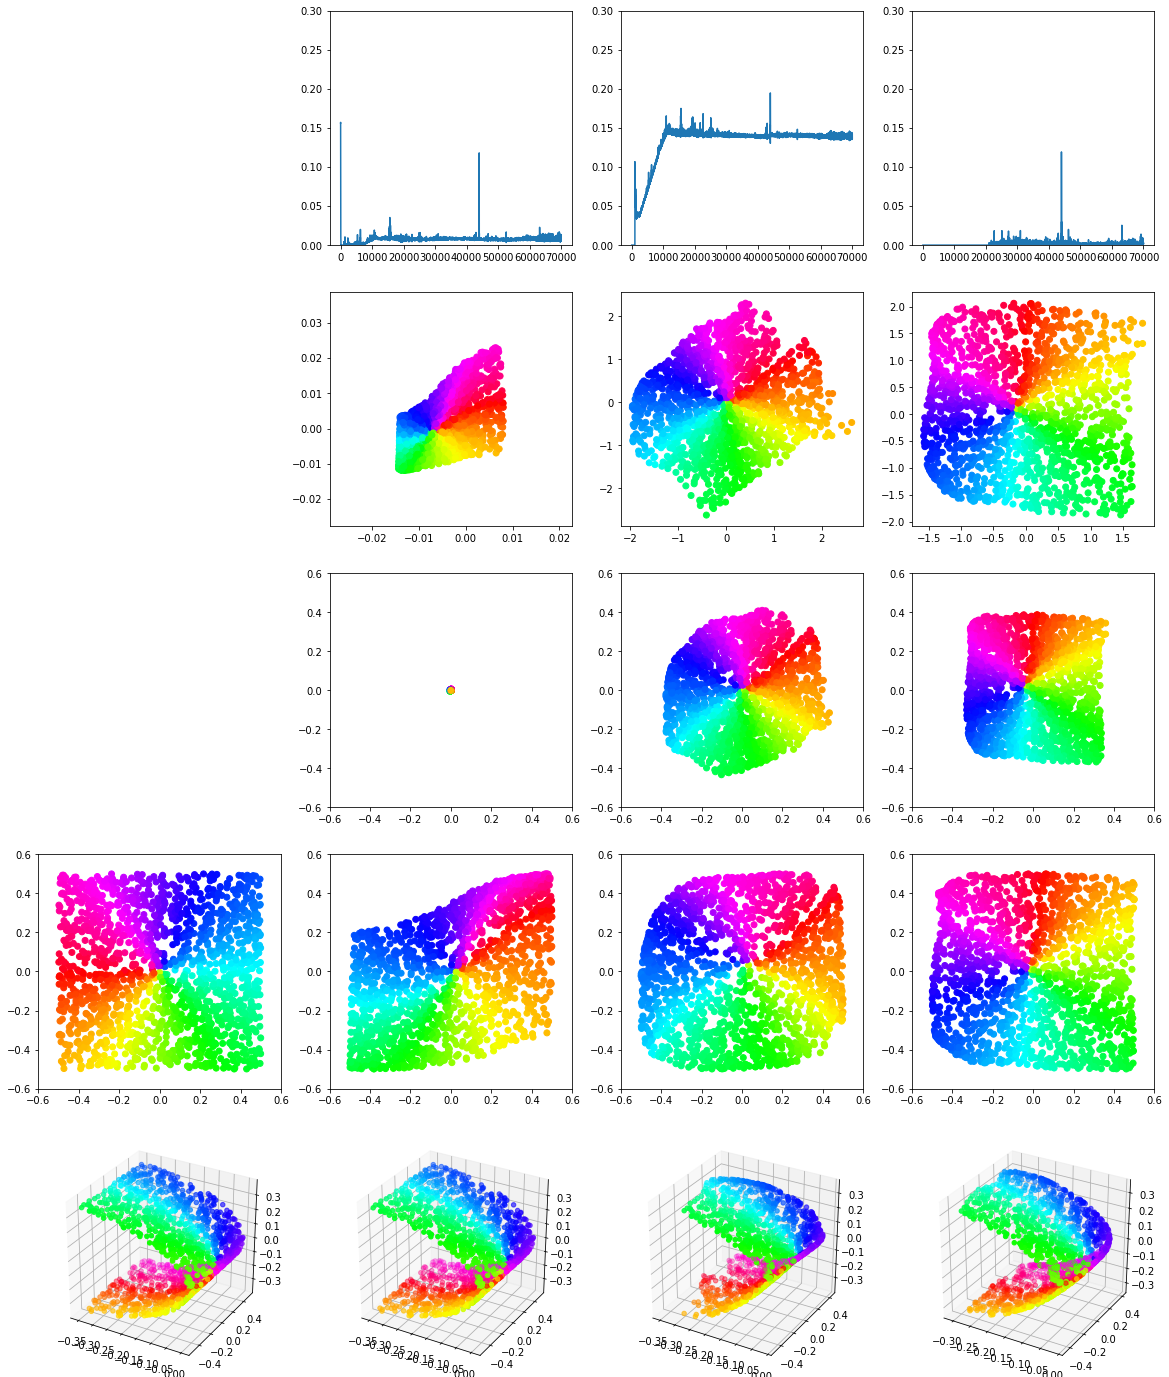

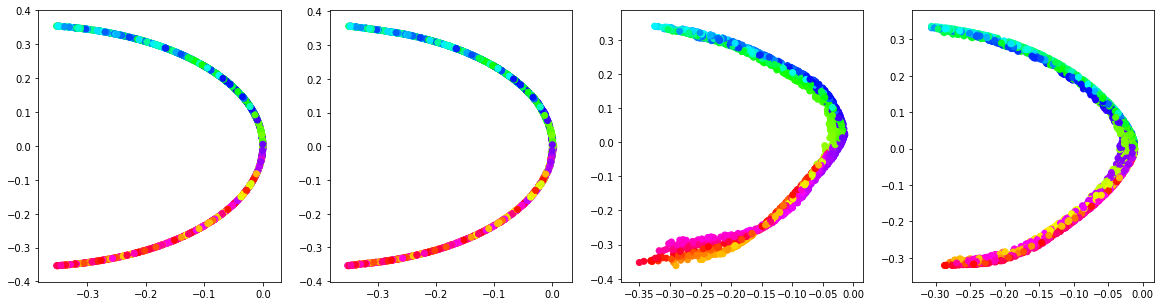

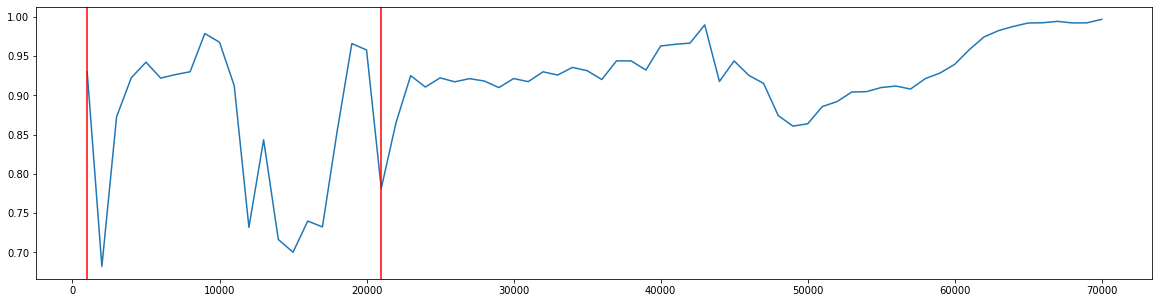

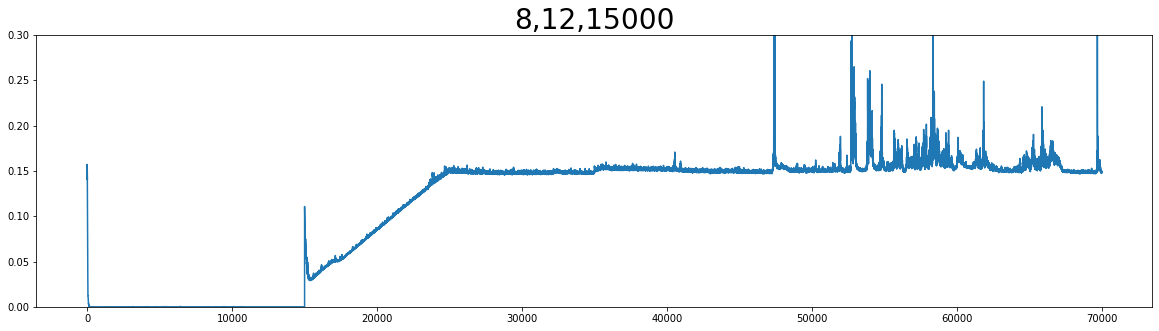

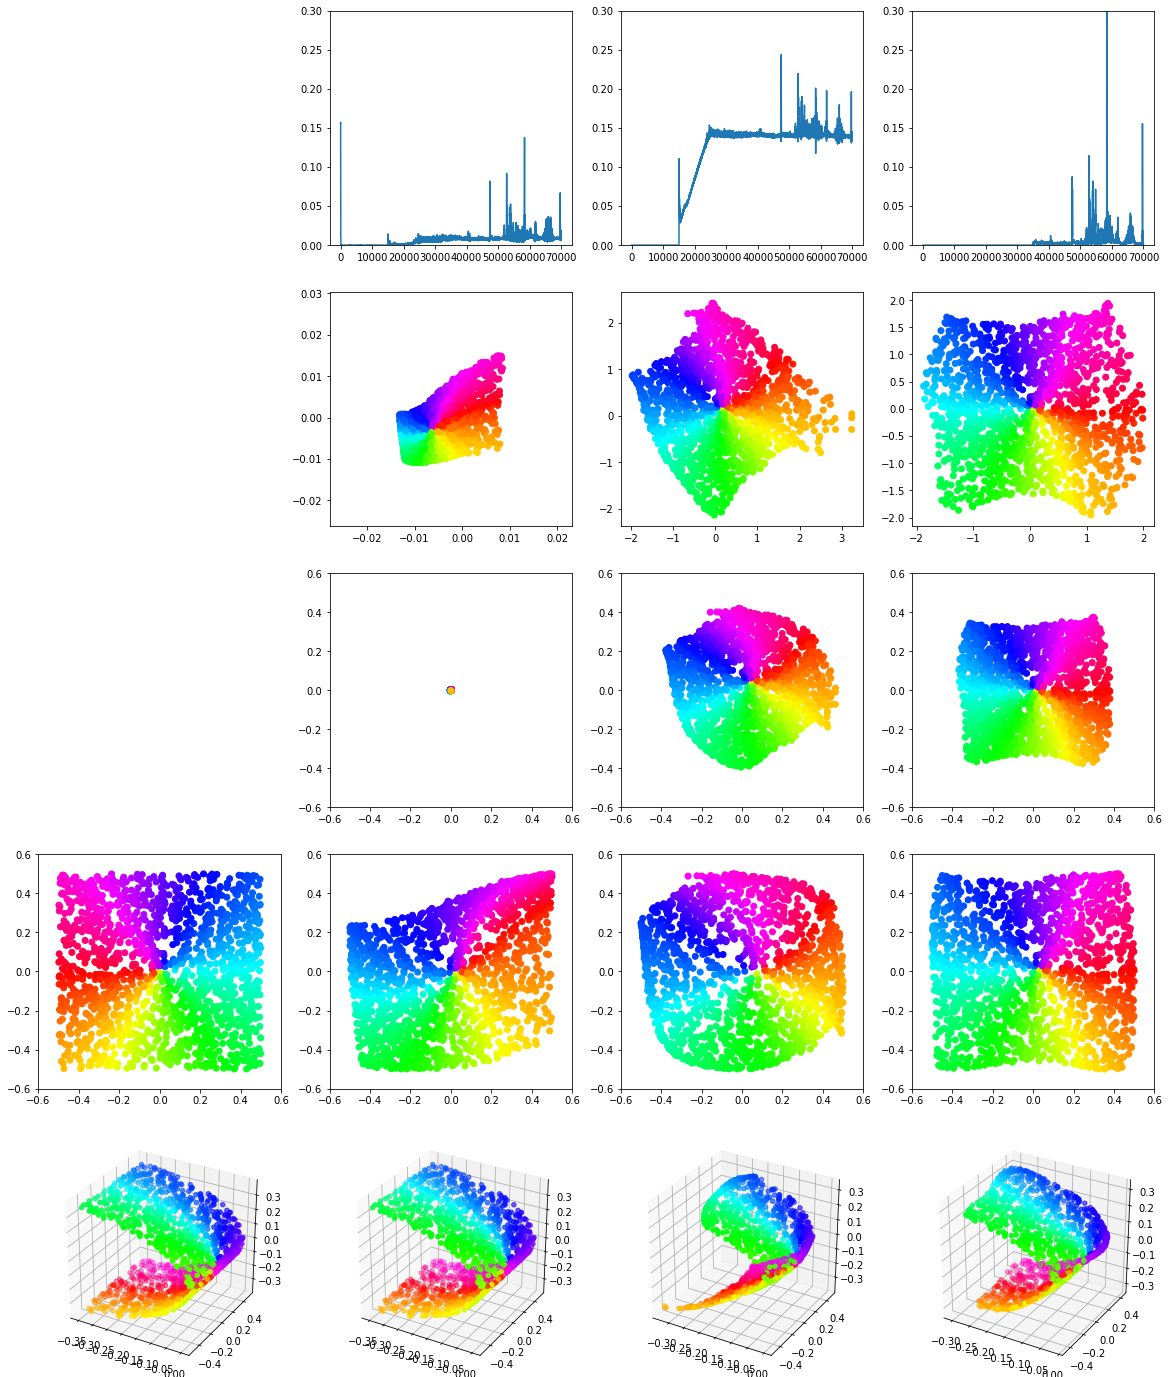

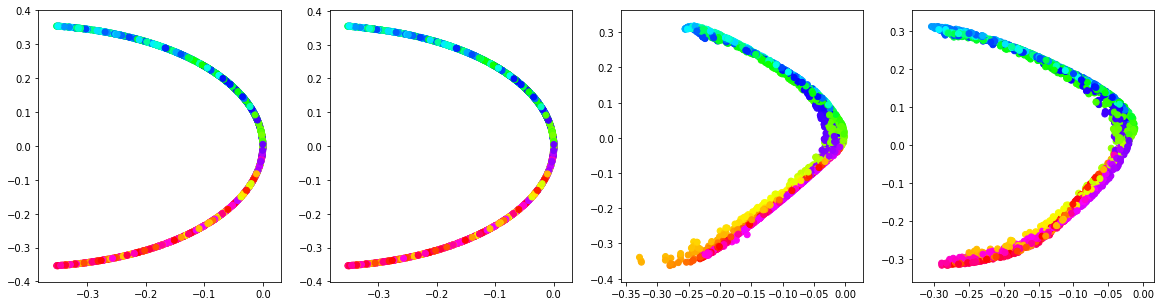

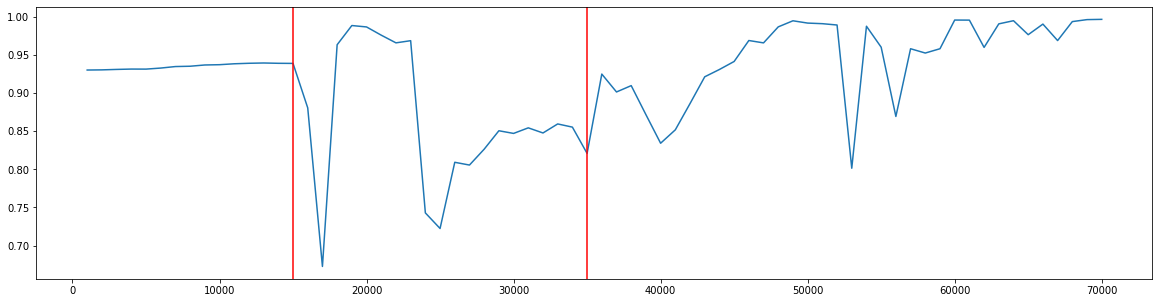

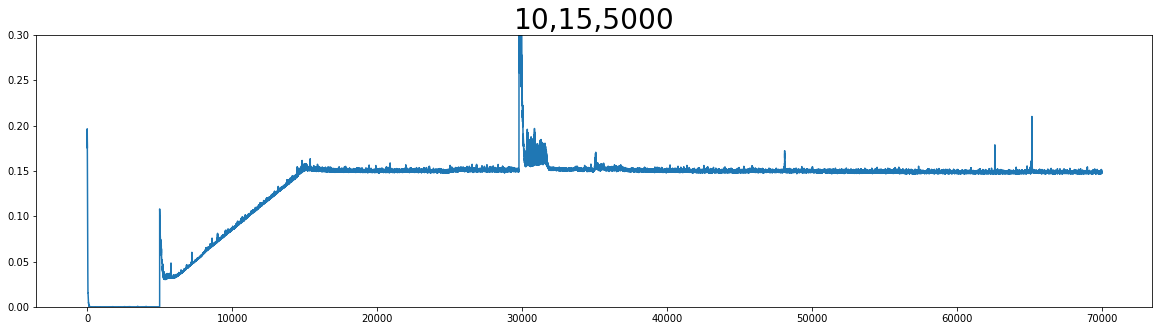

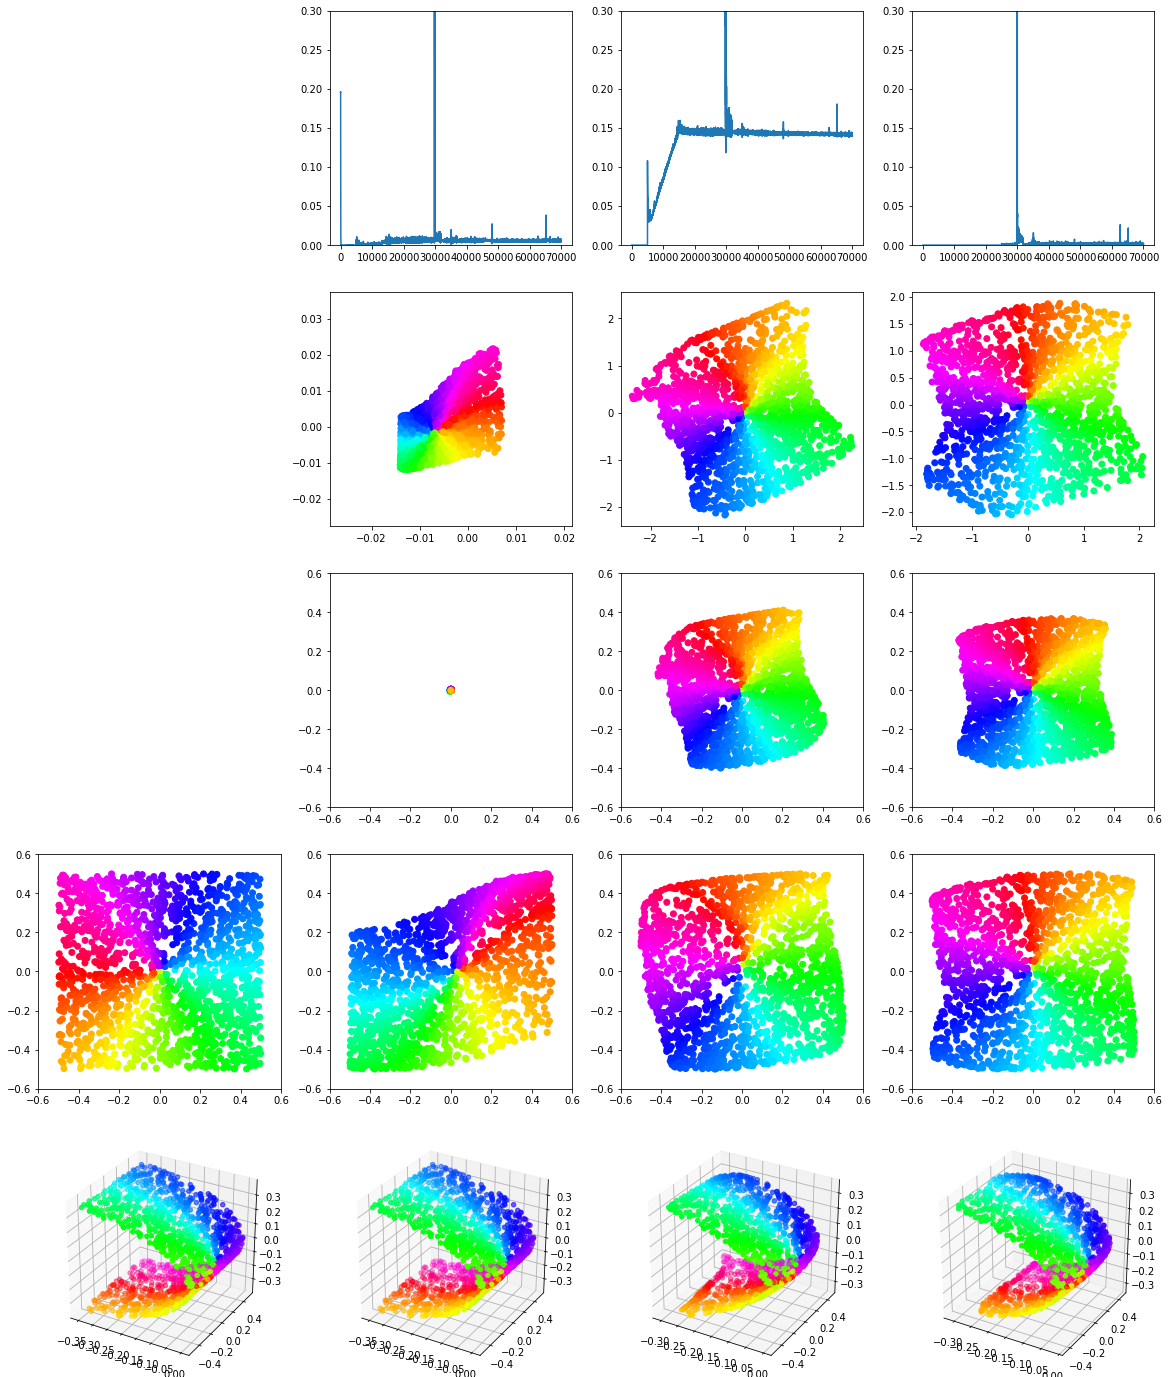

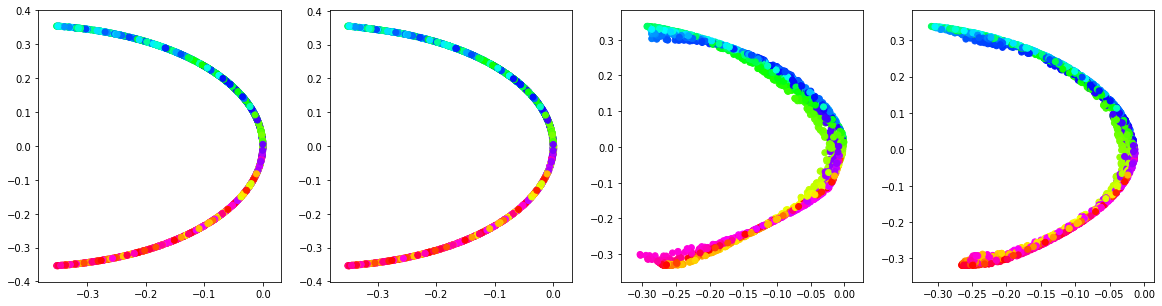

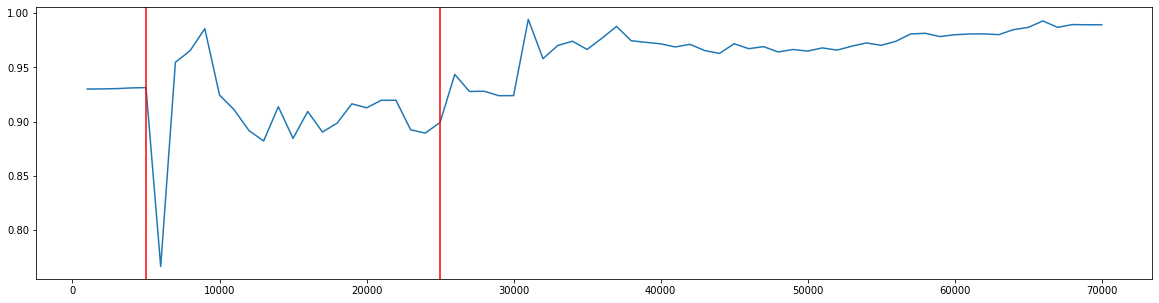

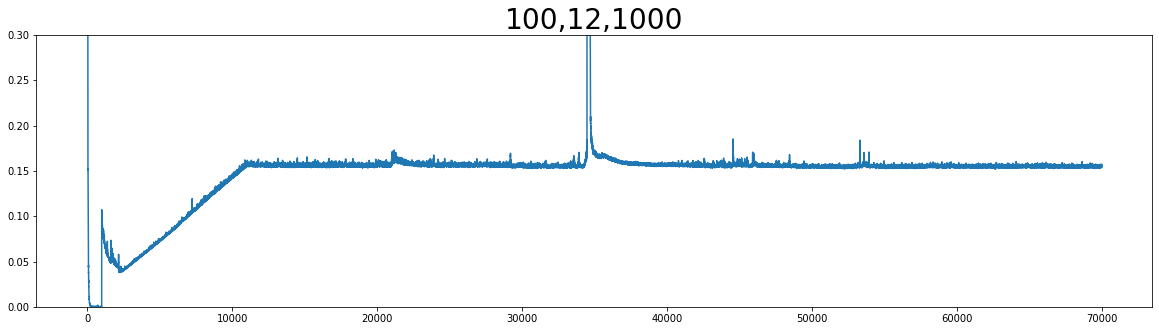

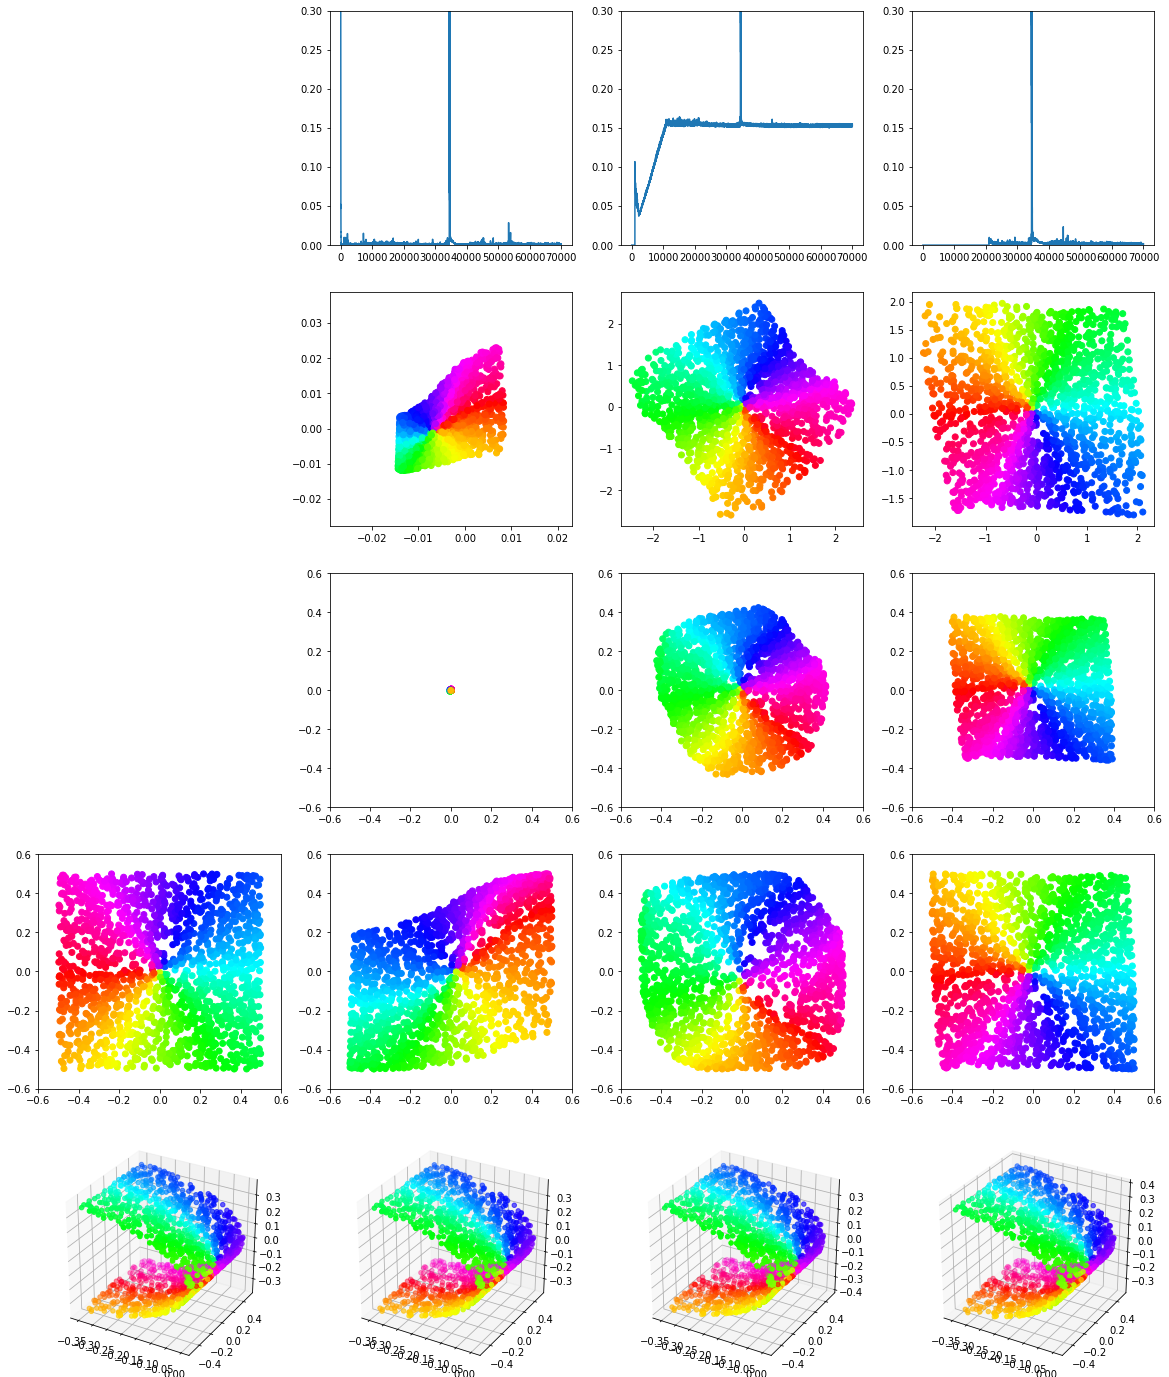

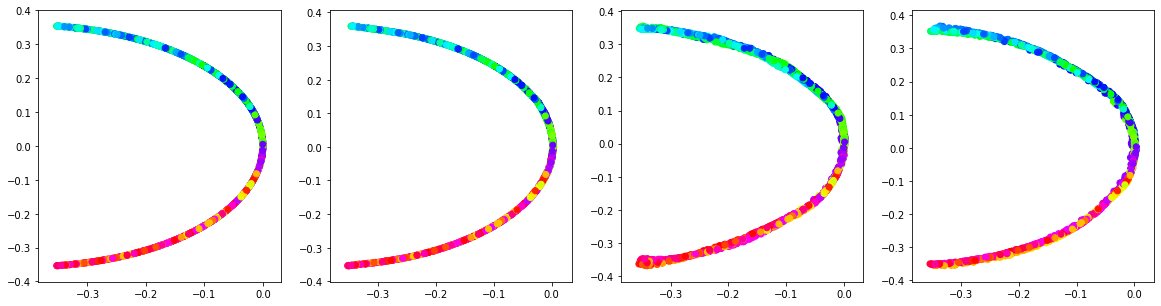

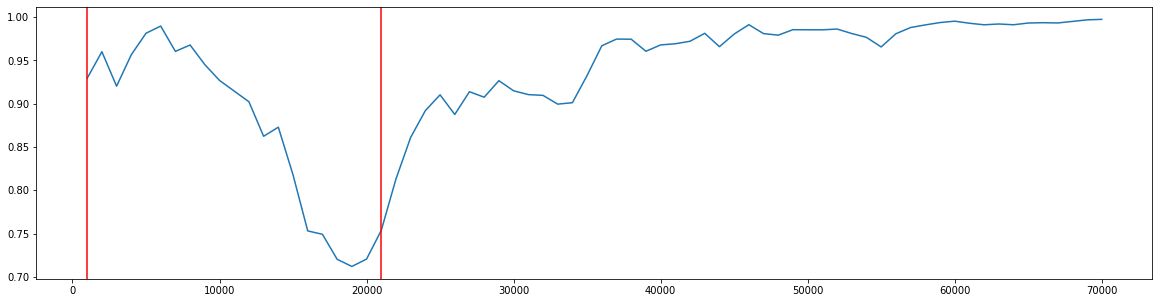

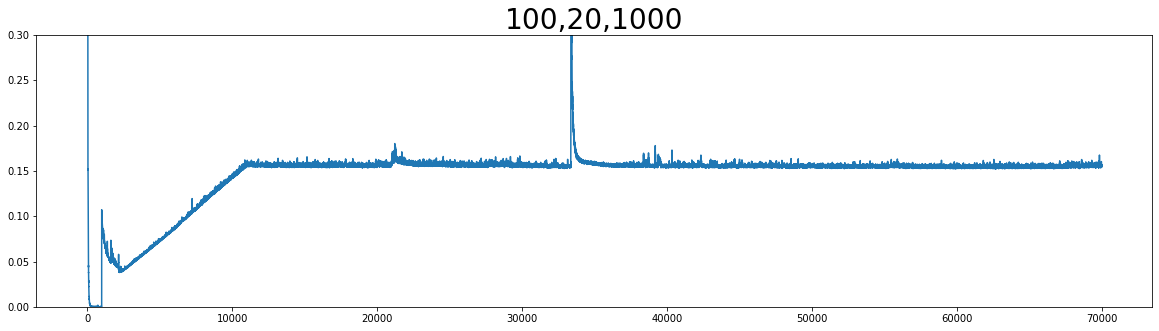

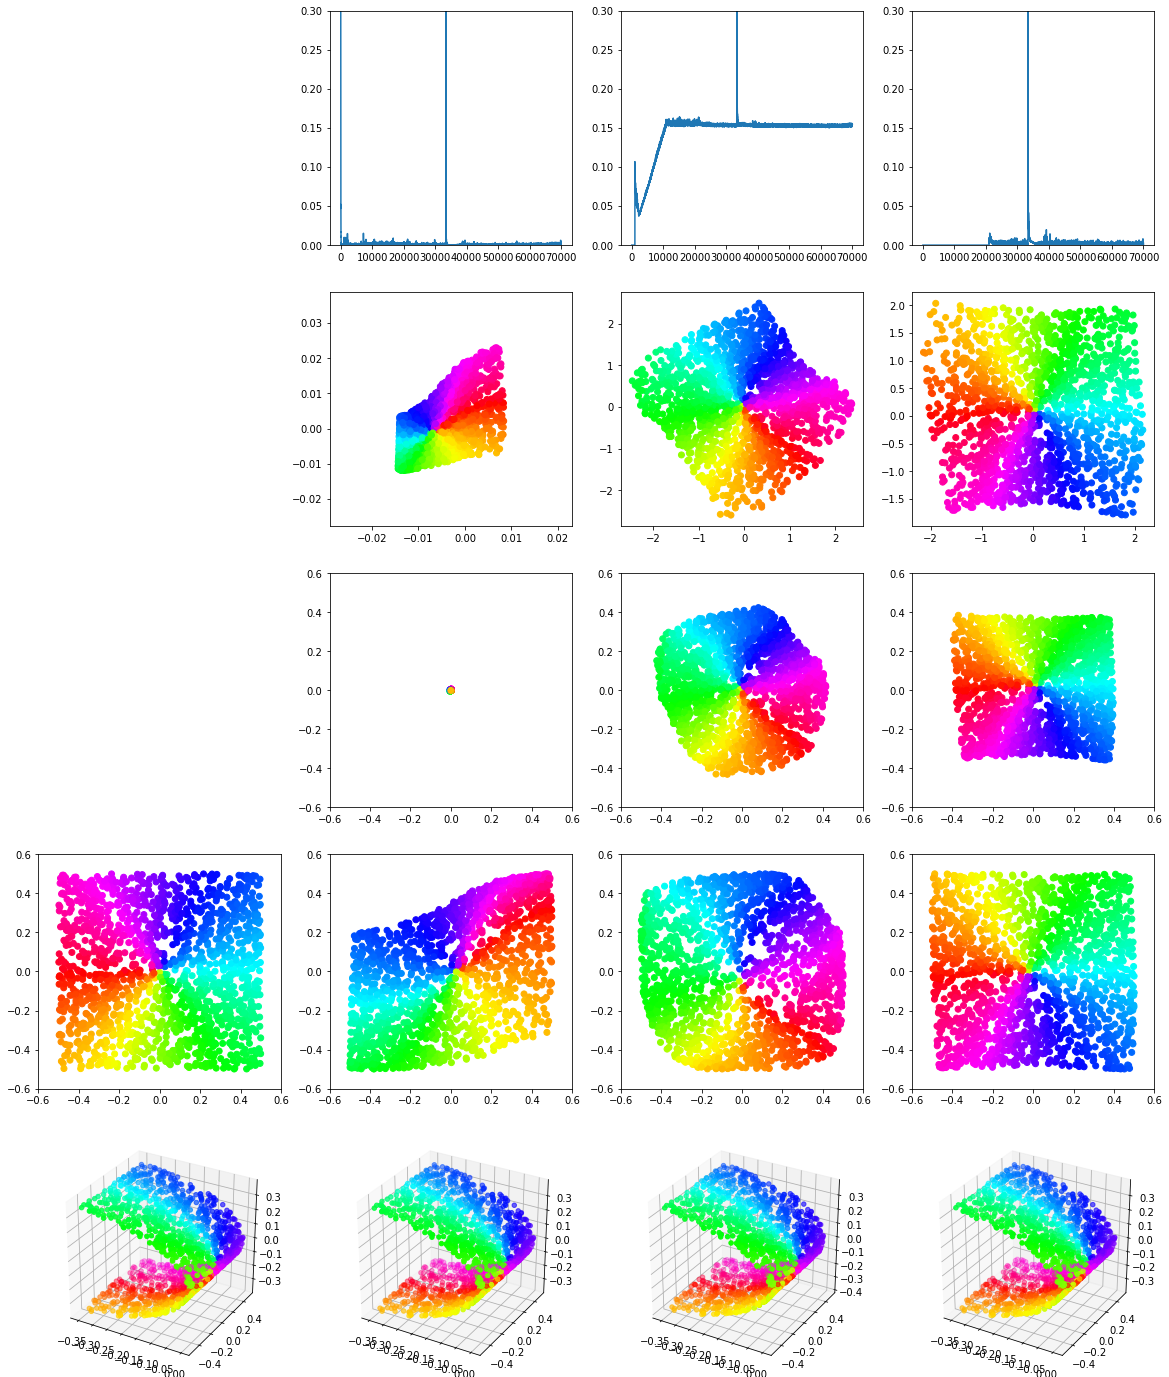

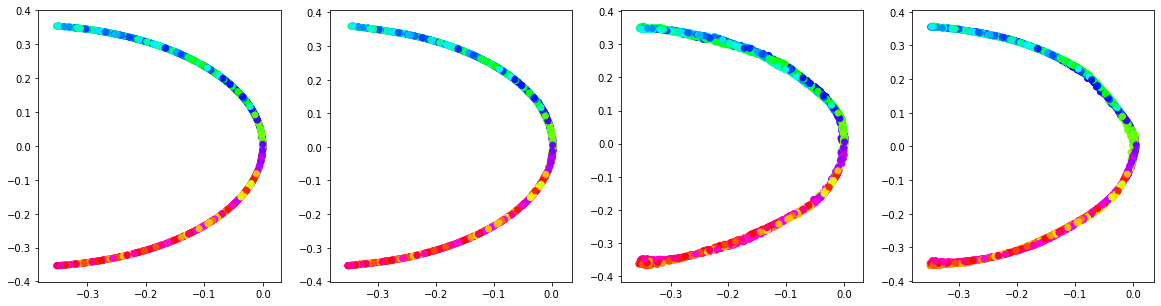

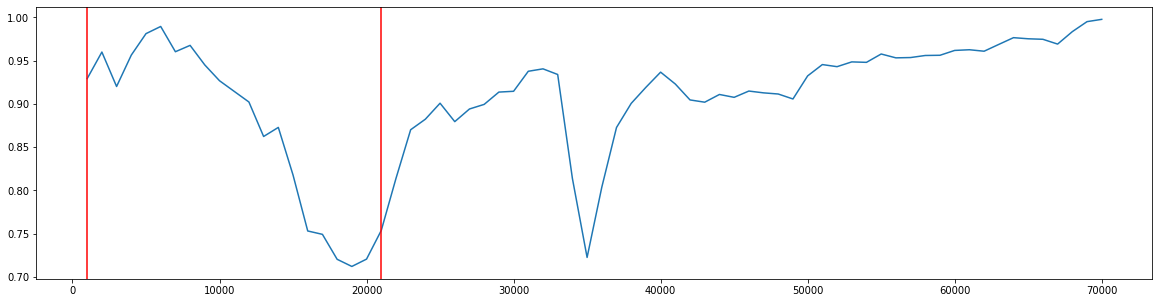

In [22]:
plot_all(8,12,1000)
plot_all(8,12,15000)
plot_all(10,15,5000)
plot_all(100,12,1000)
plot_all(100,20,1000)